In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import timeit
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

In [3]:
# Load in cleaned dataset of restaurant reviews
reviews = pickle.load( open( "restaurant_reviews_cleaned.pkl", "rb" ) )

In [4]:
reviews

,stars,text,good_bad,language,is_open,length
0,5,love deagans really atmosphere cozy festive sh...,Good,en,1.0,248
1,1,dismal lukewarm defrostedtasting texmex glop m...,Bad,en,0.0,285
2,4,oh happy day finally canes near casa yes other...,Good,en,1.0,501
3,5,definitely favorite fast food sub shop ingredi...,Good,en,1.0,355
4,5,really good place simple decor amazing food gr...,Good,en,1.0,246
...,...,...,...,...,...,...
5026161,5,confections cash casinos welcome las vegas fin...,Good,en,0.0,1014
5026162,3,solid american food southern comfort flare war...,Neutral,en,1.0,912
5026163,5,im honestly sure never place im definitely goi...,Good,en,1.0,685
5026164,3,food decent say service took way long order ev...,Neutral,en,1.0,214


In [5]:
# Creating a dataframe for performance metrics
d = {'Accuracy': [], 'Recall': [], 'F1-Score': []}
metrics = pd.DataFrame(data=d)
metrics.index.name = 'Model'
metrics

,Accuracy,Recall,F1-Score
Model,,,


# Naive Bayes Classifier

In [6]:
# Creating feature array and target array
def make_xy(reviews, vectorizer=None, min_df=0):    
    if vectorizer is None:
        vectorizer = CountVectorizer(min_df)
    X = vectorizer.fit_transform(reviews.text)
    X = X.tocsc()  # some versions of sklearn return COO format
    
    # Creating numeric target
    target_dict = {'Bad':0, 'Neutral':1, 'Good': 2}
    y = reviews.good_bad.map(target_dict)
    
    return X, y

# Timing start
start_time = timeit.default_timer()

# min_df set at 30
min_df=30
vectorizer = CountVectorizer(min_df=30, ngram_range=(1,2))
X, y = make_xy(reviews, vectorizer)

# Elapsed time calculation
elapsed = timeit.default_timer() - start_time

print('For min_df = ' + str(min_df))
print('Elapsed Time (minutes): ' + str(elapsed/60))


For min_df = 30
Elapsed Time (minutes): 85.57048309608334


In [7]:
# Investigating shape
X_n_rows, X_n_cols = X.shape[0], X.shape[1]
print('X has ' + str(X_n_rows) + ' rows, and ' + str(X_n_cols) + ' columns')

X has 5026166 rows, and 980771 columns


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB()
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

# Predictions for the test/training set
y_pred_test = nBayes.predict(X_test)
y_pred_train = nBayes.predict(X_train)

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

The training accuracy is 0.829050 and the test accuracy is 0.817571
There are 5026166 reviews and 980771 features extracted by the vectorizer


In [9]:
print(confusion_matrix(y_test, nBayes.predict(X_test)))

[[164959  45705   5402]
 [ 23426  78697  24901]
 [ 18064  65886 578194]]


In [10]:
print (classification_report(y_test, y_pred_test) )

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    216066
           1       0.41      0.62      0.50    127024
           2       0.95      0.87      0.91    662144

    accuracy                           0.82   1005234
   macro avg       0.72      0.75      0.73   1005234
weighted avg       0.85      0.82      0.83   1005234



In [11]:
# Classification reports
nbayes_report_test = classification_report(y_test, y_pred_test, output_dict = True)
nbayes_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_train['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_train['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Naive Bayes train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_test['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_test['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Naive Bayes test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8598,0.8291,0.8405
Naive Bayes test,0.8499,0.8176,0.8300


# Alpha Tuning

In [ ]:
parameters = {'alpha':[1, 5, 10, 15, 20, 25, 30, 35, 40, 45]}
grid_search = GridSearchCV(nBayes, parameters, cv=5)
grid_search.fit(X, y)


In [ ]:
sorted(grid_search.cv_results_.keys())

In [ ]:
alphas=[1, 5, 10, 15, 20, 25, 30, 35, 40, 45]
for i in range(len(alphas)):
    print('alpha = ' + str(alphas[i]))
    print('score = ' + str(grid_search.cv_results_['mean_test_score'][i]))

GridSearch_CV returns the best results as alpha=40 for min_df=10

In [ ]:
plt.plot(alphas,grid_search.cv_results_['mean_test_score'])

# Alpha = 40

In [ ]:
# Train/test split only needed if skipping above code
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Training classifier
nBayes = MultinomialNB(alpha=40)
nBayes.fit(X_train,y_train)

# Accuracy Scores
acc_train = nBayes.score(X_train, y_train)
acc_test = nBayes.score(X_test, y_test)
features = nBayes.feature_count_.shape

# Predictions for the test/training set
y_pred_test = nBayes.predict(X_test)
y_pred_train = nBayes.predict(X_train)

print('The training accuracy is %f and the test accuracy is %f' %(acc_train, acc_test))
print('There are ' + str(X_n_rows) + ' reviews' + 
      ' and ' + str(X_n_cols) + ' features extracted by the vectorizer')

In [ ]:
print ('Naive Bayes Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Naive Bayes Train Report:')
print (classification_report(y_train, y_pred_train ))

In [ ]:
# Classification reports
nbayes_report_test = classification_report(y_test, y_pred_test, output_dict = True)
nbayes_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_train['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_train['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['NB alpha 40 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(nbayes_report_test['weighted avg']['precision'], 4),
    'Recall': round(nbayes_report_test['weighted avg']['recall'],4),
    'F1-Score': round(nbayes_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['NB alpha 40 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

# Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [13]:
# Split the data into a training and test set. Only needed if not split above.
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

logRegression = LogisticRegression(solver = 'lbfgs', multi_class='auto')
# Fit the model on the trainng data.
logRegression.fit(X_train, y_train)

# Print the accuracy from the testing data.
y_pred_test = logRegression.predict(X_test)
y_pred_train = logRegression.predict(X_train)
print ('Logistic Regression Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Logistic Regression Train Report:')
print (classification_report(y_train, y_pred_train ))



/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85    216066
           1       0.59      0.40      0.48    127024
           2       0.91      0.96      0.94    662144

    accuracy                           0.87   1005234
   macro avg       0.78      0.74      0.76   1005234
weighted avg       0.86      0.87      0.86   1005234


Logistic Regression Train Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87    864264
           1       0.66      0.47      0.55    508093
           2       0.92      0.97      0.94   2648575

    accuracy                           0.89   4020932
   macro avg       0.81      0.77      0.79   4020932
weighted avg       0.88      0.89      0.88   4020932



In [14]:
# Classification reports
logReg_report_test = classification_report(y_test, y_pred_test, output_dict = True)
logReg_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_train['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_train['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(logReg_report_test['weighted avg']['precision'], 4),
    'Recall': round(logReg_report_test['weighted avg']['recall'],4),
    'F1-Score': round(logReg_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Logistic Regression test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8598,0.8291,0.8405
Naive Bayes test,0.8499,0.8176,0.8300
Logistic Regression train,0.8758,0.8851,0.8779
Logistic Regression test,0.8566,0.8690,0.8603


# Feature Importance - Logistic Regression Coefficients

In [16]:
cols = X.shape[1]
arr = np.empty(shape=cols)
for i in range(cols):
    arr[i] = np.std(X[:, i].toarray())

In [17]:
arr.shape

(980771,)

In [18]:
influence = logRegression.coef_[0,:]*arr

In [22]:
most_influential_indicies_bad_reviews = np.argsort(logRegression.coef_[0,:]*arr)[-30:]
most_influential_indicies_neutral_reviews = np.argsort(logRegression.coef_[1,:]*arr)[-10:]
most_influential_indicies_good_reviews = np.argsort(logRegression.coef_[2,:]*arr)[-30:]

In [23]:
influential_words = {'Good' : {}, 'Neutral': {}, 'Bad':{}}
bad_words = []
good_words = []
neutral_words = []
bad_scores = []
good_scores = []

print('Influential Words for Bad Reviews')
print('')
for word_loc in most_influential_indicies_bad_reviews:
    print(list(vectorizer.get_feature_names())[word_loc])
    bad_words.append(list(vectorizer.get_feature_names())[word_loc])
    influential_words['Bad'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]
    bad_scores
    
print('')
print('Influential Words for Good Reiews')
print('')
    
for word_loc in most_influential_indicies_good_reviews:
    print(list(vectorizer.get_feature_names())[word_loc])
    good_words.append(list(vectorizer.get_feature_names())[word_loc])
    influential_words['Good'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]
    
print('')
print('Influential Words for Neutral Reiews')
print('')
    
for word_loc in most_influential_indicies_neutral_reviews:
    print(list(vectorizer.get_feature_names())[word_loc])
    neutral_words.append(list(vectorizer.get_feature_names())[word_loc])  
    influential_words['Neutral'][str(list(vectorizer.get_feature_names())[word_loc])] = vectorizer.vocabulary_[str(list(vectorizer.get_feature_names())[word_loc])]


Influential Words for Bad Reviews

never return
salty
nothing
sad
soggy
place
told
cold
service
never
sorry
food
tasteless
overpriced
awful
returning
dirty
dry
disgusting
ordered
disappointed
poor
mediocre
bland
disappointing
rude
terrible
two stars
horrible
worst

Influential Words for Good Reiews

go wrong
well worth
happy
glad
gem
really good
incredible
love place
yummy
definitely coming
perfection
definitely back
perfectly
thank
loved
favorite
wonderful
cant wait
never disappointed
good
highly recommend
awesome
fantastic
love
perfect
best
excellent
amazing
delicious
great

Influential Words for Neutral Reiews

bad
35
average
stars
okay
decent
mediocre
aok
three stars
ok


In [24]:
pickle.dump(influential_words, open( "log_reg_influential_words_bigrams.pickle", "wb" ) )

# Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = pickle.load( open( "X_vectorized_min_df_20.pickle", "rb" ) )

In [ ]:
y = pickle.load( open( 'y_vectorized_min_df_20.pickle', 'rb' ))

In [ ]:
## Only needed if not split above

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [26]:
# Random Forest Model using all processing cores
rForest = RandomForestClassifier(n_estimators=300, max_features='log2', max_depth=20, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300building tree 3 of 300


building tree 4 of 300
building tree 5 of 300
building tree 6 of 300building tree 7 of 300building tree 8 of 300


building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300building tree 14 of 300

building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.7s


building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300building tree 73 of 300

building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min


building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [27]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)
print ('Test Report:')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:  4.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.0min
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 15.3min finished


Test Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62    216066
           1       0.29      0.35      0.32    127024
           2       0.83      0.81      0.82    662144

    accuracy                           0.71   1005234
   macro avg       0.59      0.59      0.59   1005234
weighted avg       0.72      0.71      0.71   1005234


Train Report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63    864264
           1       0.31      0.36      0.33    508093
           2       0.83      0.81      0.82   2648575

    accuracy                           0.71   4020932
   macro avg       0.59      0.60      0.59   4020932
weighted avg       0.72      0.71      0.72   4020932



In [28]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8598,0.8291,0.8405
Naive Bayes test,0.8499,0.8176,0.8300
Logistic Regression train,0.8758,0.8851,0.8779
Logistic Regression test,0.8566,0.8690,0.8603
Random Forest train,0.7236,0.7135,0.7181
Random Forest test,0.7187,0.7079,0.7128


In [29]:
rForest = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=50, 
                                 class_weight='balanced', 
                                 n_jobs = -1, verbose=2)
rForest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 1000building tree 2 of 1000

building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000building tree 15 of 1000

building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.2s


building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building tree 41 of 1000
building tree 42 of 1000
building tree 43 of 1000
building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000
building tree 49 of 1000
building tree 50 of 1000
building tree 51 of 1000
building tree 52 of 1000
building tree 53 of 1000
building tree 54 of 1000
building tree 55 of 1000
building tree 56 of 1000
building tree 57 of 1000
building tree 58 of 1000
building tree 59 of 1000
building tree 60 of 1000
building tree 61 of 1000
building tree 62 of 1000
building tree 63 of 1000
building tree 64 of 1000
building tree 65 of 1000
building tree 66 of 1000
building tree 67 of 1000
building tree 68 of 1000
building tree 69 of 1000
building tree 70 of 1000
building tree 71 of 1000
building tree 72 of 1000
building tree 73 of 1000
building tree 74 of 1000
building tree 75 of 1000
building tree 76 of 1000
building tree 77 of 1000


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min


building tree 158 of 1000
building tree 159 of 1000
building tree 160 of 1000
building tree 161 of 1000
building tree 162 of 1000
building tree 163 of 1000
building tree 164 of 1000
building tree 165 of 1000
building tree 166 of 1000
building tree 167 of 1000
building tree 168 of 1000
building tree 169 of 1000
building tree 170 of 1000
building tree 171 of 1000
building tree 172 of 1000
building tree 173 of 1000
building tree 174 of 1000
building tree 175 of 1000
building tree 176 of 1000
building tree 177 of 1000
building tree 178 of 1000
building tree 179 of 1000
building tree 180 of 1000
building tree 181 of 1000
building tree 182 of 1000
building tree 183 of 1000
building tree 184 of 1000
building tree 185 of 1000
building tree 186 of 1000building tree 187 of 1000

building tree 188 of 1000
building tree 189 of 1000
building tree 190 of 1000
building tree 191 of 1000
building tree 192 of 1000
building tree 193 of 1000
building tree 194 of 1000
building tree 195 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.5min


building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tree 379 of 1000
building tree 380 of 1000
building tree 381 of 1000
building tree 382 of 1000
building tree 383 of 1000
building tree 384 of 1000
building tree 385 of 1000
building tree 386 of 1000
building tree 387 of 1000
building tree 388 of 1000
building tree 389 of 1000
building tree 390 of 1000
building tree 391 of 1000
building tree 392 of 1000
building tree 393 of 1000
building tree 394 of 1000
building tree 395 of 1000
building tree 396 of 1000
building tree 397 of 1000
building tree 398 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 17.5min


building tree 644 of 1000
building tree 645 of 1000
building tree 646 of 1000
building tree 647 of 1000
building tree 648 of 1000
building tree 649 of 1000
building tree 650 of 1000
building tree 651 of 1000
building tree 652 of 1000
building tree 653 of 1000
building tree 654 of 1000
building tree 655 of 1000
building tree 656 of 1000
building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tre

building tree 960 of 1000
building tree 961 of 1000
building tree 962 of 1000
building tree 963 of 1000
building tree 964 of 1000
building tree 965 of 1000
building tree 966 of 1000
building tree 967 of 1000
building tree 968 of 1000
building tree 969 of 1000
building tree 970 of 1000
building tree 971 of 1000
building tree 972 of 1000
building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 29.2min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='log2',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=2, warm_start=False)

In [30]:
# Print the accuracy from the training & testing data.
y_pred_test = rForest.predict(X_test)
y_pred_train = rForest.predict(X_train)

print ('Random Forest -- 1000/50/log2')
print ('')
print ('Random Forest Test Report')
print (classification_report(y_test, y_pred_test ))
print ('')
print ('Random Forest Train Report:')
print (classification_report(y_train, y_pred_train ))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 13.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 34.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed: 53.6min finished


Random Forest -- 1000/50/log2

Random Forest Test Report
              precision    recall  f1-score   support

           0       0.77      0.68      0.72    216066
           1       0.37      0.40      0.38    127024
           2       0.86      0.87      0.86    662144

    accuracy                           0.77   1005234
   macro avg       0.67      0.65      0.66   1005234
weighted avg       0.78      0.77      0.77   1005234


Random Forest Train Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75    864264
           1       0.43      0.46      0.45    508093
           2       0.86      0.89      0.88   2648575

    accuracy                           0.79   4020932
   macro avg       0.70      0.68      0.69   4020932
weighted avg       0.80      0.79      0.79   4020932



In [31]:
# Classification reports
rForest_report_test = classification_report(y_test, y_pred_test, output_dict = True)
rForest_report_train = classification_report(y_train, y_pred_train, output_dict = True)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_train['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_train['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_train['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 1000 train'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Adding metrics to the metrics dataframe
d = {'Accuracy': round(rForest_report_test['weighted avg']['precision'], 4),
    'Recall': round(rForest_report_test['weighted avg']['recall'],4),
    'F1-Score': round(rForest_report_test['weighted avg']['f1-score'],4)}
temp = pd.DataFrame(data=d, index=['Random Forest 1000 test'])
temp.index.name = 'Model'
metrics = metrics.append(temp)

# Viewing dataframe
metrics

,Accuracy,Recall,F1-Score
Model,,,
Naive Bayes train,0.8598,0.8291,0.8405
Naive Bayes test,0.8499,0.8176,0.8300
Logistic Regression train,0.8758,0.8851,0.8779
Logistic Regression test,0.8566,0.8690,0.8603
Random Forest train,0.7236,0.7135,0.7181
Random Forest test,0.7187,0.7079,0.7128
Random Forest 1000 train,0.7959,0.7945,0.7943
Random Forest 1000 test,0.7763,0.7725,0.7736


# Feature Importance -- Random Forest

In [32]:
# Feature Importance
importances = rForest.feature_importances_

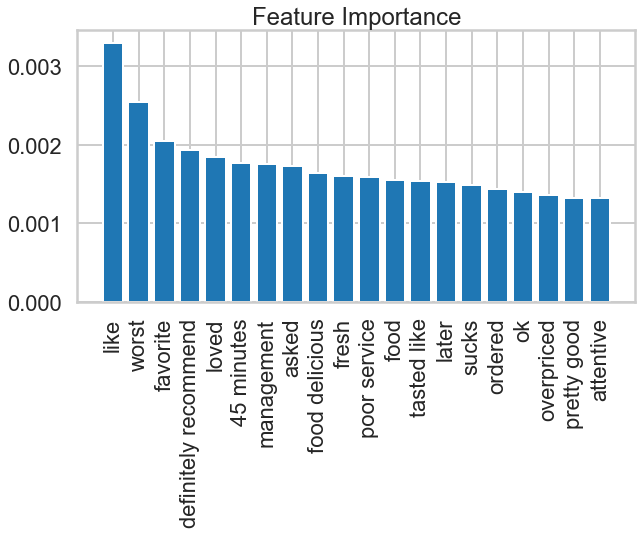

In [33]:
# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
feature_names = list(vectorizer.get_feature_names())
labels = np.array(feature_names)[sorted_index]

# Create Bar Chart
plt.figure(figsize=(10,5))
plt.bar(x[0:20], importances[sorted_index][0:20], tick_label=labels[0:20])

# Rotate tick labels to vertical

plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()